In [1]:
import os
from os.path import join
import torch
import torch.nn as nn
import math
import pandas as pd
import imageio
from skimage import img_as_ubyte
from scipy.ndimage.morphology import binary_dilation
from itertools import product
from typing import List
from tqdm import tqdm_notebook
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes, Textures
from pytorch3d.transforms import Rotate, Translate
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.renderer import (
    SfMPerspectiveCameras, OpenGLPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights
)
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency
)
from dataclasses import dataclass, field, asdict, astuple
import numpy as np
#Plotting Libs
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
import time
from copy import deepcopy

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from utils.shapes import Sphere, SphericalSpiral
from utils.manager import RenderManager, ImageManager

['/home/alexis/Desktop/E3D', '/home/alexis/Desktop/E3D', '/home/alexis/anaconda3/envs/pytorch3d/lib/python37.zip', '/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7', '/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7/lib-dynload', '', '/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7/site-packages', '/home/alexis/Desktop/pytorch3d', '/home/alexis/Desktop/E3D/v2e', '/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7/site-packages/IPython/extensions', '/home/alexis/.ipython']


In [2]:
from v2e.emulator import EventEmulator
from v2e.renderer import EventRenderer

In [3]:
#Matplotlib config nums
mpl.rcParams['savefig.dpi'] = 90
mpl.rcParams['figure.dpi'] = 90
#Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device == "cuda:0": torch.cuda.set_device()

### Single Obj

In [4]:
#Load the object without textures and materials
mesh_name = "plane"
verts, faces_idx, _ = load_obj(f"data/meshes/{mesh_name}.obj")
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = Textures(verts_rgb=verts_rgb.to(device))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch.
teapot_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

/home/alexis/Desktop/pytorch3d/pytorch3d/io/obj_io.py:70: UserWarning:

Faces have invalid indices



### Multi Obj

In [5]:
### SOME BIG FAT TODO HERE

### Create a renderer

In [6]:
cameras = SfMPerspectiveCameras(device=device)


# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
# edges. Refer to blending.py for more details. 
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 256x256. To form the blended image we use 100 faces for each pixel. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=64, 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=100, 
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)


# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=128, 
    blur_radius=0.0, 
    faces_per_pixel=100, 
)
# We can add a point light in front of the object. 
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device=device, lights=lights, cameras=cameras)
)

### v2e Parameters

In [7]:
@dataclass
class V2EEmulatorParams: 
    pos_thres: float = 0.2 #Positive threshold
    neg_thres: float = 0.2#Negative Threshold
    sigma_thres: float = .03#Sigma Threshold
    cutoff_hz: int = 300 #Second-order IIR lowpass filter
    leak_rate_hz: float = .01 #per pixel leak event rate in Hz
    shot_noise_rate_hz: float = .001 #Noise rate of ON+OFF events
    dvs_params: str = None #"noisy" or "clean" - this will explicitly reset everything else above
    output_folder: str = "data/dump"
    dvs_h5: str = "test.h5"#Output as h5 database
    dvs_aedat2: str = "test.aedat"#Output as AEDAT-2.0 event file
    dvs_text: str = "test.txt"#Output as txt file

@dataclass
class V2ERendererParams:
    output_path: str = "data/dump"
    dvs_vid: str = "dvs-video.avi"#Output DVS events as AVI video with given frame rate
    dvs_vid_full_scale: int = "2" #Set full scale event count histogram
    preview: bool = False #Disables cv2 preview 
    exposure_mode: str = "duration"#Mode to finish event integration:
        #duration s: fixed accumulation in s e.g "duration .005"
        #count n: Count n events per frame e.g "count 5000"
        #area_event N M: frame ends when any area of M x N pixels
        #fills with N events e.g "area_count 500 64"
    exposure_val: float = .01 #Corresponds to the value from above
    area_dimension: tuple = None#Area dimension from area event

### Create Emulator Object

In [10]:
emulator = EventEmulator(
    output_folder = "data/dump",
    dvs_text = "test")
emulator.set_dvs_params("noisy")

eventRenderer = EventRenderer(
    output_path = "data/dump", 
    preview = False)

### Emulate events sequentially

1
Starting
Initializing log_frame


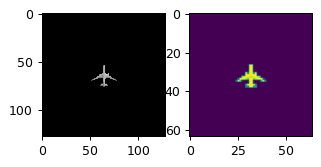

2
Starting


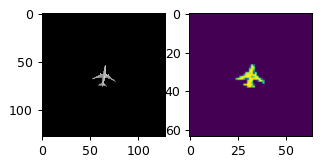

3
Starting


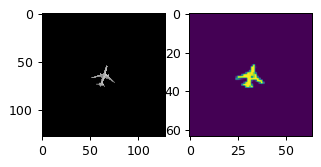

4
Starting


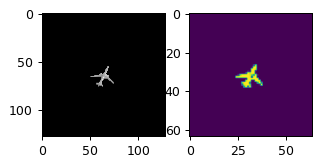

In [ ]:
def cam_trajectory_rotation(num_points: int = 4):
    """
    Returns: list of camera poses (R,T) from trajectory along a spherical spiral
    """
    
    shape = SphericalSpiral(
        c = 6,
        a = 3,
        t_min = 1*math.pi,
        t_max=1.05*math.pi,
        num_points=num_points)
    up = torch.tensor([[1., 0., 0.]])
    R = []
    T = []
    for cp in shape._tuples:
        cp = torch.tensor(cp).to(device)
        R_new = look_at_rotation(cp[None, :], device=device)
        T_new = -torch.bmm(R_new.transpose(1,2), cp[None, :, None])[:, :, 0]
        if not len(R) and not len(T):
            R = [R_new]
            T = [T_new]
        else:
            R.append(R_new)
            T.append(T_new)
    return (torch.stack(R)[:,0,:], torch.stack(T)[:,0,:])

def cam_trajectory_transform(
    dist: float = 2.7,
    elev_range: list= [100],
    azim_range: list= [0, 20],
    batch_size: int = 4):
    """
    Input
    Returns cameras from ranges of elevations and azimuths
    
    Not going to use this for now
    """
    
    elev = torch.tensor([50] * batch_size)
    azim = torch.linspace(azim_range[0], azim_range[1], batch_size)
    R, T = look_at_view_transform(dist=2, elev=elev, azim=azim, device=device)
    return (R, T)
    
def render_trajectory(cam_poses, write_gif=True):
    
    renders = {
        "phong": None,
        "silhouette": None,
        "events": None
    }
    events = np.zeros((0,4), dtype = np.float32)
    batch_size = 8
    #render_manager = RenderManager(
    #    types=list(renders.keys()),
    #    mesh_name = "mesh_name"
    #)
    # Render the teapot providing the values of R and T.
    R, T = cam_poses
    for num in range(1, len(R) + 1):
        if "phong" in renders.keys():
            image_ref = phong_renderer(meshes_world=teapot_mesh, R=R[num-1:num:], T=T[num-1:num:])
            image_ref = image_ref.cpu().numpy()
            plt.subplot(131)
            plt.imshow(image_ref.squeeze())
        if "silhouette" in renders.keys():
            silhouette = silhouette_renderer(meshes_world=teapot_mesh, R=R[num-1:num:], T=T[num-1:num:])
            silhouette = silhouette.cpu().numpy()
            plt.subplot(132)
            plt.imshow(silhouette.squeeze()[...,3])  # only plot the alpha channel of the RGBA image 
        #render_manager.add_images(
        #    num,
        #    {"silhouette": silhouette.squeeze()[...,3], "phong": image_ref.squeeze()},
        #   R[num-1:num:], T[num-1:num:])
        if "events" in renders.keys():
            print(num)
            newEvents = emulator.generate_events(image_ref, num)
            if newEvents is not None and newEvents.shape[0] > 0:
                events = np.append(events, newEvents, axis=0)
                events = np.array(events)
                if num%batch_size==0:
                    eventRenderer.render_events_to_frames(events, height=128, width=128)
                    events = np.zeros((0, 4), dtype=np.float32)  # clear array
        plt.show()
    if len(events)>0: # process leftover
        eventRenderer.render_events_to_frames(events, height=128, width=128) 
        
    #render_manager.close()
    #return render_manager

    
cam_poses = cam_trajectory_transform()
render = render_trajectory(cam_poses)